In [13]:
import time
from collections import Counter
import numpy as np
import pandas as pd
from numpy.random import permutation
import seaborn as sns
import matplotlib.pyplot as plt

from tpot import TPOTClassifier
from tpot.config import classifier_config_dict

from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss, f1_score, confusion_matrix
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

In [14]:
train = pd.read_csv('../data/train.csv', index_col='index')
test = pd.read_csv('../data/test.csv', index_col='index')

In [15]:
train = train.fillna('inoccupation')
test = test.fillna('inoccupation')
categorical_columns = set(train.columns) - set(train.describe().columns)

# categorical_columns = set(train.columns) - set(train.describe().columns) - set(train.isna().sum()[train.isna().sum()!=0].index)
# train = train.drop('occyp_type', axis=1)
# test = test.drop('occyp_type', axis=1)

In [16]:
label_encoders = []
for c in categorical_columns:
    encoder = LabelEncoder()
    train[c] = encoder.fit_transform(train[c])
    test[c] = encoder.transform(test[c])
    label_encoders.append(encoder)

<Figure size 432x288 with 0 Axes>

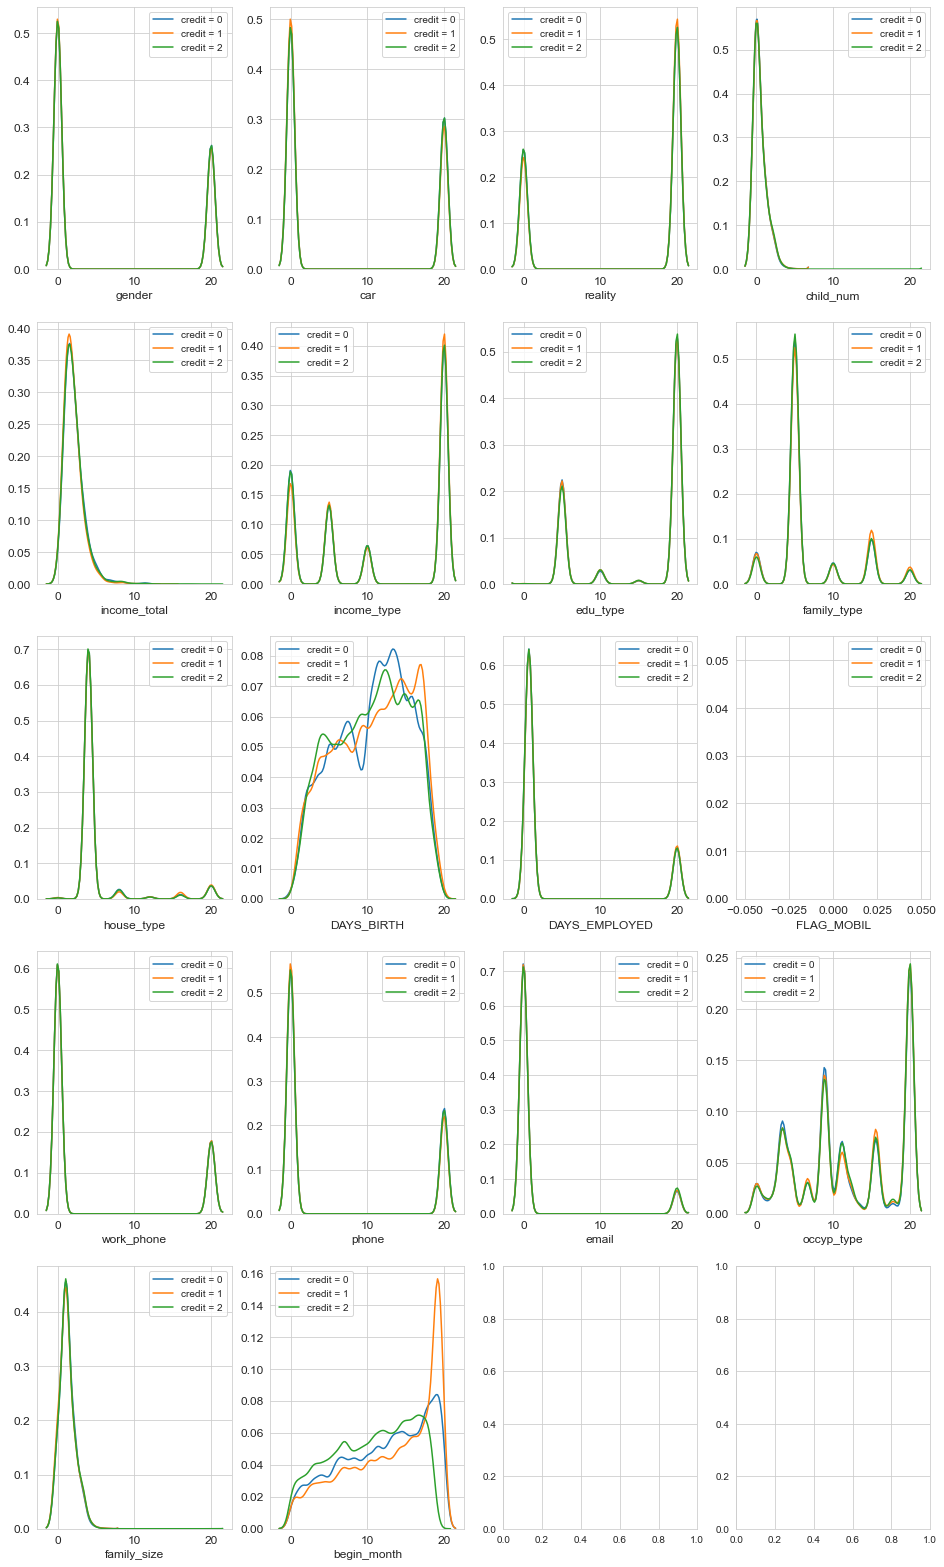

In [17]:
# feature별, label별 분포확인
scaler = MinMaxScaler((0,20))
temp = train.drop('credit', axis=1)
temp = pd.DataFrame(scaler.fit_transform(temp), columns=temp.columns)
train_temp = pd.concat([temp, train['credit']], axis=1)

var = train_temp.columns.values[:-1]
i = 0
t0 = train_temp.loc[train_temp['credit'] == 0]
t1 = train_temp.loc[train_temp['credit'] == 1]
t2 = train_temp.loc[train_temp['credit'] == 2]

sns.set_style('whitegrid') # 그래프 스타일 지정
plt.figure()
fig, ax = plt.subplots(len(train.columns)//4+1, 4, figsize = (16, 28)) # 축 지정

for feature in var:
    i += 1
    plt.subplot(len(train_temp.columns)//4+1, 4, i) # 28개의 그래프
    sns.kdeplot(t0[feature], bw = 0.5, label = "credit = 0")
    sns.kdeplot(t1[feature], bw = 0.5, label = "credit = 1")
    sns.kdeplot(t2[feature], bw = 0.5, label = "credit = 2")
    plt.xlabel(feature, fontsize = 12) # 라벨 속성값
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()

In [18]:
# label별 분포 차이가 없는 feature 제외
x_train = train.drop(['gender', 'FLAG_MOBIL', 'car', 'reality', 'phone', 'email'], axis=1).copy()
x_test = test.drop(['gender', 'FLAG_MOBIL', 'car', 'reality', 'phone', 'email'], axis=1).copy()
y_train = x_train.pop('credit')
Counter(y_train)

Counter({1.0: 6267, 2.0: 16968, 0.0: 3222})

In [19]:
# 오분류 데이터 카운트
miss_count = pd.Series({i:0 for i in range(len(y_train))}, index=y_train.index)
for i in range(50):
    data_index = [data_index for data_index in range(x_train.shape[0])]
    random_data_index = np.random.choice(data_index, int(x_train.shape[0]))
    model = make_pipeline(
        MaxAbsScaler(),
        RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.55, min_samples_leaf=1, \
                               min_samples_split=18, n_estimators=100)
    )
    model.fit(X=x_train.iloc[random_data_index,], y=y_train.iloc[random_data_index,])
    y_pred = model.predict(x_train)
    temp = (y_train != y_pred)
    miss_count.iloc[temp[temp==True].index] += 1
    
# 오분류 횟수가 많고 major집단에 포함된 데이터 outlier취급, 제거
t2 = y_train[y_train==2].index
outlier = list(set(t2) & set(miss_count[miss_count>40].index))
x_train_drop_outlier = x_train.drop(outlier).reset_index().drop('index', axis=1)
y_train_drop_outlier = y_train.drop(outlier).reset_index()['credit']
print(len(outlier))

29


In [8]:
# dbscan으로 군집화
minor_miss_idx = list(set(miss_count[miss_count > 0].index) - set(outlier))

cluster_model = DBSCAN(eps=50000, min_samples=20)
predict = pd.DataFrame(cluster_model.fit_predict(x_train.iloc[minor_miss_idx]))
predict.index = x_train.iloc[minor_miss_idx].index
predict.columns=['predict']
x_train_dbscan = pd.concat([x_train,predict],axis=1)
dbscan_label = predict['predict'].unique()
for l in dbscan_label:
    c_idx = x_train_dbscan[x_train_dbscan['predict']==l].index
    print(Counter(y_train.iloc[c_idx]))

Counter({1.0: 4191, 2.0: 4052, 0.0: 2659})
Counter({1.0: 908, 2.0: 862, 0.0: 536})
Counter({2.0: 11, 1.0: 9, 0.0: 8})


In [49]:
# 데이터 수가 작은 군집은 outlier취급
c_idx = x_train_dbscan[x_train_dbscan['predict']==dbscan_label[-1]].index
outlier_idx = y_train_drop_outlier[c_idx][y_train_drop_outlier[c_idx]==2].index
x_train_drop_outlier2 = x_train_drop_outlier.drop(outlier_idx).reset_index().drop('index', axis=1)
y_train_drop_outlier2 = y_train_drop_outlier.drop(outlier_idx).reset_index()['credit']
print(len(outlier_idx))

13


In [10]:
# 국지적 smote
# dbscan 결과에 따라 수정해야함 (군집에 포함된 데이터 수 많으면 해당 군집도 smote해야함)
flag = 0
for i in range(2):
    c_idx = x_train_dbscan[x_train_dbscan['predict']==dbscan_label[i]].index
    smote_on_0 = int(len(y_train.iloc[c_idx][y_train.iloc[c_idx]==0]) * 1.2)
#     smote_on_1 = int(len(y_train.iloc[c_idx][y_train.iloc[c_idx]==1]) * 1.3)
    print(Counter(y_train.iloc[c_idx]))
    sm = SMOTE(sampling_strategy={0:smote_on_0}, k_neighbors=5, random_state=42)
    x_train_res, y_train_res = sm.fit_resample(x_train.iloc[c_idx], y_train.iloc[c_idx].ravel())
    y_train_res = pd.Series(y_train_res)
    print(Counter(y_train_res))

    if flag:
        x_temp = x_dropoutlier_smote.iloc[list(set(x_dropoutlier_smote.index) - set(c_idx))]
        y_temp = y_dropoutlier_smote.iloc[list(set(y_dropoutlier_smote.index) - set(c_idx))]
    else:
        flag = 1
        x_temp = x_train_drop_outlier.iloc[list(set(x_train_drop_outlier.index) - set(c_idx))]
        y_temp = y_train_drop_outlier.iloc[list(set(y_train_drop_outlier.index) - set(c_idx))]
    x_dropoutlier_smote = pd.concat([x_temp, x_train_res]).reset_index().drop('index', axis=1)
    y_dropoutlier_smote = pd.concat([y_temp, y_train_res]).reset_index().drop('index', axis=1)[0]
    print(Counter(y_dropoutlier_smote))
    print()

Counter({1.0: 4191, 2.0: 4052, 0.0: 2659})
Counter({1.0: 4191, 2.0: 4052, 0.0: 3456})
Counter({2.0: 14035, 1.0: 7821, 0.0: 5378})

Counter({1.0: 908, 2.0: 862, 0.0: 536})
Counter({1.0: 908, 2.0: 862, 0.0: 696})
Counter({2.0: 13656, 1.0: 8070, 0.0: 5668})



In [8]:
# 전체적 smote
smote_on_0 = int(len(y_train[y_train==0]) * 1.4)
smote_on_1 = int(len(y_train[y_train==1]) * 1.4)
sm = SMOTE(sampling_strategy={0:smote_on_0, 1:smote_on_1}, k_neighbors=5, random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
y_train_res = pd.Series(y_train_res)
Counter(y_train_res)

Counter({1.0: 8773, 2.0: 16968, 0.0: 4510})

In [ ]:
classifier_config_dict['xgboost.XGBClassifier'] = {
    'n_estimators': [100],
    'max_depth': range(3, 20),
    'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
    'subsample': np.arange(0.7, 1.01, 0.05),
    'min_child_weight': range(1, 25),
    'n_jobs': [2], # replace "nthread"
    'verbosity': [0]
}

In [ ]:
x = x_train_res
y = y_train_res

models = []
bagging_predict_result_train = []
bagging_predict_result_test = []
for i in range(10):
#     data_index = [data_index for data_index in range(x.shape[0])]
#     random_data_index = np.random.choice(data_index, int(x.shape[0]))
    tpot = TPOTClassifier(generations=2, population_size=30, verbosity=2, config_dict=classifier_config_dict)
#     tpot.fit(x.iloc[random_data_index], y.iloc[random_data_index])
    tpot.fit(x, y)
    bagging_predict_result_train.append(tpot.predict_proba(x_train))
    bagging_predict_result_test.append(tpot.predict_proba(x_test))
    models.append(tpot)


Generation 1 - Current best internal CV score: 0.7063250797969326

Generation 2 - Current best internal CV score: 0.7115477886996343

Best pipeline: XGBClassifier(LogisticRegression(input_matrix, C=20.0, dual=False, penalty=l2), learning_rate=0.5, max_depth=10, min_child_weight=1, n_estimators=100, n_jobs=2, subsample=0.9000000000000001, verbosity=0)



Generation 1 - Current best internal CV score: 0.6636483280545119

Generation 2 - Current best internal CV score: 0.667284549647555

Best pipeline: XGBClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=9, max_features=0.45, min_samples_leaf=16, min_samples_split=14, n_estimators=100, subsample=0.6000000000000001), learning_rate=0.1, max_depth=3, min_child_weight=11, n_estimators=100, n_jobs=2, subsample=0.8500000000000001, verbosity=0)


In [9]:
# 전체에 대한 결과
mean_y_pred_prob_train = np.array(bagging_predict_result_train).mean(axis=0)
print(f'log loss: {log_loss(y_train, mean_y_pred_prob_train)}')
print(f'f1 score: {f1_score(y_train, np.argmax(mean_y_pred_prob_train, axis=1), average="macro")}')
confusion_matrix(y_train, np.argmax(mean_y_pred_prob_train, axis=1))

log loss: 0.23736238429548626
f1 score: 0.9376698453937392


array([[ 2819,    91,   312],
       [   68,  5736,   463],
       [  100,   171, 16697]], dtype=int64)

In [12]:
# 모든 모델에 대해 ensemble한 결과 저장
mean_y_pred_prob = np.array(bagging_predict_result_test).mean(axis=0)
pd.DataFrame(mean_y_pred_prob).set_index(test.index).to_csv('./submission/result_dropoutlier_smoteall_nonrestore_RF_ensemble.csv')

In [10]:
# 개별 모델에 대한 결과
best_model = -1
best_model_score = 100
log_loss_list = []
for i in range(len(bagging_predict_result_train)):
    lloss = log_loss(y_train, bagging_predict_result_train[i])
    log_loss_list.append(lloss)
    if lloss < best_model_score:
        best_model_score = lloss
        best_model = i
    print(f'log loss: {lloss}')
    print(f'f1 score: {f1_score(y_train, np.argmax(bagging_predict_result_train[i], axis=1), average="macro")}')
    print()

log loss: 0.03981748545170788
f1 score: 0.9639122174768531

log loss: 0.4596091775846287
f1 score: 0.7356697016088812

log loss: 0.29970616686286755
f1 score: 0.8731057105301107

log loss: 0.305575313382829
f1 score: 0.8900630447452492

log loss: 0.34790564226766135
f1 score: 0.8314530623037579

log loss: 0.4074269066681387
f1 score: 0.7686518460655072

log loss: 0.11438786166569931
f1 score: 0.9280047774355845

log loss: 0.4028725038979427
f1 score: 0.7750854454355132

log loss: 0.04415385374460643
f1 score: 0.9631578326135618

log loss: 0.27026296203295436
f1 score: 0.8516067752857789



In [11]:
# 개별 모델중 베스트 저장
models[best_model].export('./model/pipeline_dropoutlier_smoteall_nonrestore_best.py')
t = models[best_model].predict_proba(x_test)
pd.DataFrame(t).set_index(test.index).to_csv('./submission/result_dropoutlier_smoteall_nonrestore_RF.csv')

In [15]:
# 모든 모델 저장
for i in range(len(models)):
    if i != best_model:
        models[i].export('./model/pipeline_dropoutlier_smoteall_nonrestore_RF' + str(i) + '_' + \
                         str(round(log_loss_list[i],4)) + '.py')

In [13]:
# log loss가 0.5이하인 모델을 대상으로 ensemble결과 도출
good_models_predict = []
for i in range(len(bagging_predict_result_train)):
    lloss = log_loss(y_train, bagging_predict_result_train[i])
    if lloss < 0.5:
        good_models_predict.append(models[i].predict_proba(x_test))

In [14]:
mean_y_pred_prob = np.array(good_models_predict).mean(axis=0)
pd.DataFrame(mean_y_pred_prob).set_index(test.index).to_csv('./submission/result_dropoutlier_smoteall_nonrestore_RF_good_model_ensemble.csv')